<a href="https://colab.research.google.com/github/AndyDengFKu/DPA1/blob/main/A2_resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import h5py
import os
import torch
import pickle
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
from PIL import Image
from torch.utils.data import DataLoader, random_split, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models.resnet import ResNet18_Weights
from torchvision import transforms
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.manifold import TSNE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Calculated normalized mean and std
normalized_mean = 165 / 255
normalized_std = 65 / 255

# Update global constants for pixel normalization
PIXEL_MEAN = [normalized_mean, normalized_mean, normalized_mean]
PIXEL_STD = [normalized_std, normalized_std, normalized_std]

# 1. Define the custom dataset class
class CustomDatasetFromHDF5(Dataset):
    def __init__(self, h5_file, transform=None, subset=None):
        self.transform = transform
        with h5py.File(h5_file, 'r') as db:
            if subset == "train":
                self.images = db['train_images'][:]
                self.labels = db['train_labels'][:]
            elif subset == "val":
                self.images = db['val_images'][:]
                self.labels = db['val_labels'][:]
            elif subset == "test":
                self.images = db['test_images'][:]
                self.labels = db['test_labels'][:]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image = Image.fromarray(self.images[index])
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label

# 2. Define data augmentation and normalization
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=PIXEL_MEAN, std=PIXEL_STD)
])

# 3. Load the datasets
data_path = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/cropped_data.h5'
train_dataset = CustomDatasetFromHDF5(data_path, transform=data_transforms, subset="train")
val_dataset = CustomDatasetFromHDF5(data_path, transform=data_transforms, subset="val")

batch_size = 64
# 4. DataLoader for batch processing
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# 5. Visualize some sample images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = PIXEL_STD * inp + PIXEL_MEAN
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


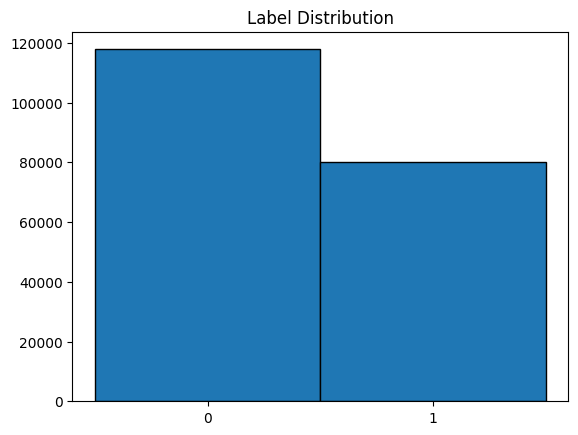

In [ ]:
# Create new dataset class for loading labels only
class CustomLabelDatasetFromHDF5(Dataset):
    def __init__(self, h5_file):
        with h5py.File(h5_file, 'r') as db:
            self.labels = np.array(db['train_labels'])  # Load all labels at once

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.labels[index]

data_path = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/cropped_data.h5'
label_dataset = CustomLabelDatasetFromHDF5(data_path)

# Show tag distribution
def show_label_distribution(labels):
    plt.hist(labels, bins=np.arange(3)-0.5, edgecolor='k', align='mid')
    plt.xticks([0,1])
    plt.title("Label Distribution")
    plt.show()

show_label_distribution(label_dataset.labels)

In [ ]:
def image_statistics(dataloader):
    total_images = 0
    mean_sum = np.zeros(3)
    variance_sum = np.zeros(3)

    for inputs, _ in dataloader:
        images = inputs.numpy()
        total_images += images.shape[0]

        # Update the mean and variance sum for each batch
        mean_sum += images.mean(axis=(0,2,3)) * images.shape[0]
        variance_sum += ((images - mean_sum[None, :, None, None] / total_images) ** 2).sum(axis=(0,2,3))

    # Compute overall mean and standard deviation
    overall_mean = mean_sum / total_images
    overall_std = np.sqrt(variance_sum / total_images)

    print(f"Image Mean: {overall_mean}")
    print(f"Image Std: {overall_std}")

image_statistics(dataloader)

Image Mean: [0.2847554  0.00134475 0.27710981]
Image Std: [18.30194017 19.31143144 17.3155578 ]


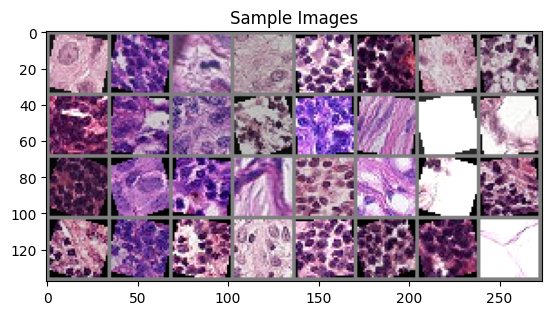

In [ ]:
# Show some sample images
imshow(out, title="Sample Images")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 14.9MB/s]


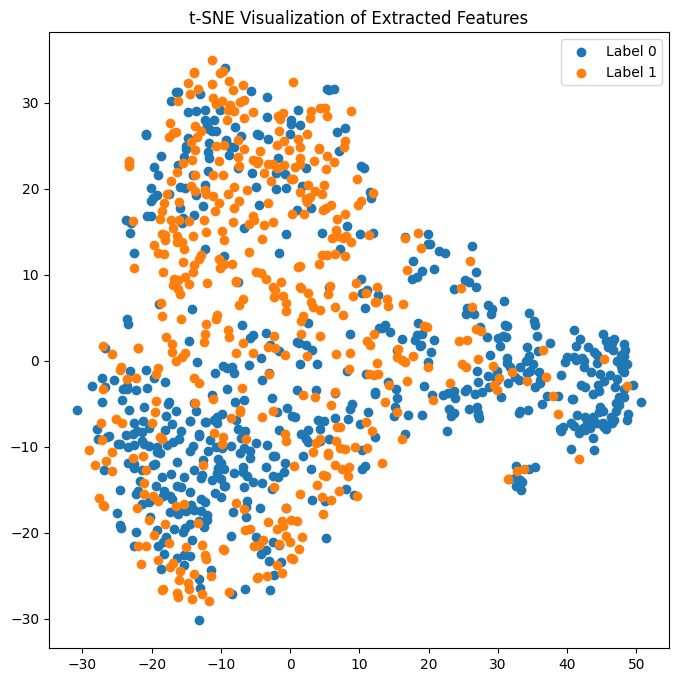

In [ ]:
# Initialize the model outside the function
model = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model = model.eval().cuda()

def extract_features_and_visualize(dataloader, num_samples=1000):
    features_list = []
    labels_list = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            if i * dataloader.batch_size > num_samples:
                break
            inputs = inputs.cuda()
            features = model(inputs)
            # Adjust the shape of the feature
            features = features.squeeze(-1).squeeze(-1)
            features_list.append(features.cpu().numpy())
            labels_list.extend(labels.numpy())

    # Merge all features
    features_array = np.concatenate(features_list, axis=0)

    # Use t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=0)
    tsne_results = tsne.fit_transform(features_array)

    # Visualisation of t-SNE results
    plt.figure(figsize=(8,8))
    for label in [0, 1]:
        idx = np.array(labels_list) == label
        plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], label=f"Label {label}")

    plt.legend()
    plt.title("t-SNE Visualization of Extracted Features")
    plt.show()

extract_features_and_visualize(dataloader)

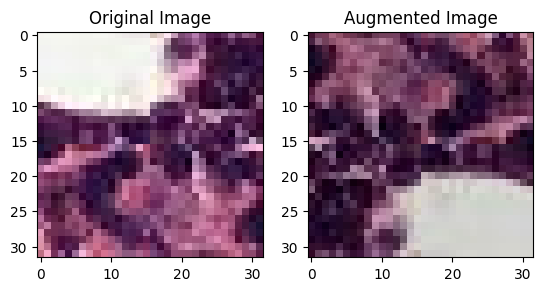

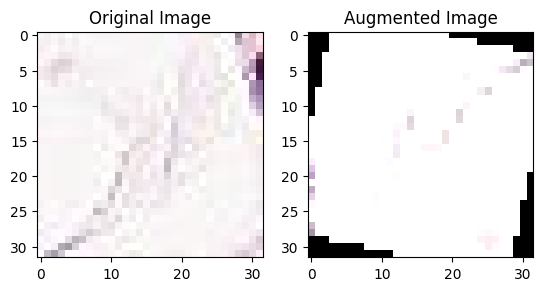

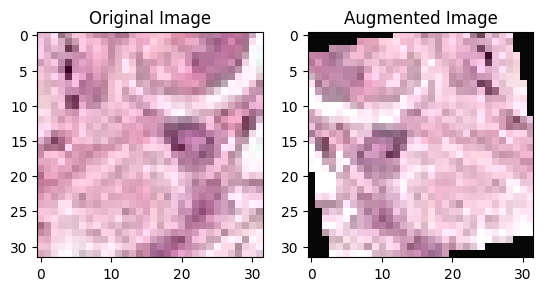

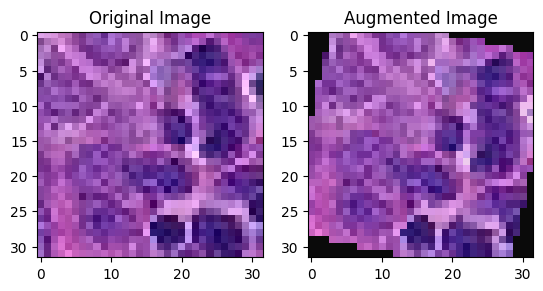

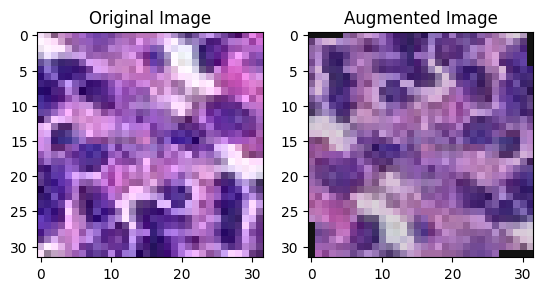

In [ ]:
# Data enhancement effects
def show_augmentation_effects(dataset, original_dataset, num_samples=5):
    for i in range(num_samples):
        original_image, _ = original_dataset[i]
        augmented_image, _ = dataset[i]

        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(original_image)
        ax[0].set_title("Original Image")

        augmented_image = augmented_image.numpy().transpose((1, 2, 0))
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        augmented_image = std * augmented_image + mean

        ax[1].imshow(augmented_image)
        ax[1].set_title("Augmented Image")
        plt.show()

original_dataset = CustomDatasetFromHDF5(data_path, transform=None)
show_augmentation_effects(dataset, original_dataset)

Mean Pixel Intensity: 0.1874464476006572
Standard Deviation of Pixel Intensities: 0.5877169016943307
Outliers are expected outside the range: [0, 1]


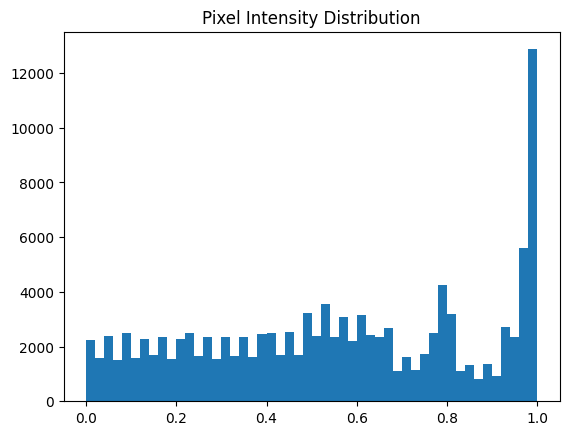

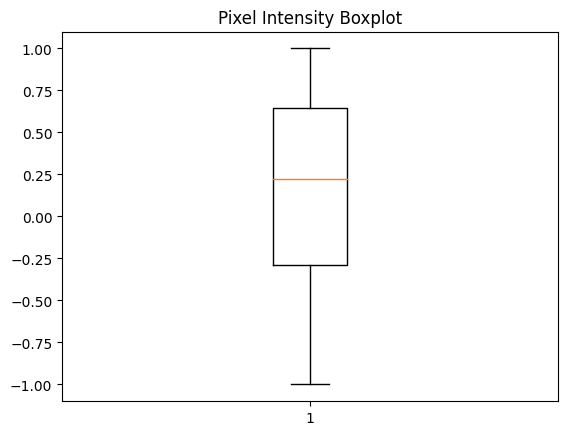

In [ ]:
def detect_outliers(dataloader):
    total_pixel_count = 0
    intensity_sum = 0
    squared_intensity_sum = 0

    for inputs, _ in dataloader:
        pixel_values = inputs.numpy().ravel()
        total_pixel_count += len(pixel_values)

        # Update the sum of intensities and squared intensities for each batch
        intensity_sum += pixel_values.sum()
        squared_intensity_sum += (pixel_values ** 2).sum()

    # Compute overall mean and standard deviation
    mean_intensity = intensity_sum / total_pixel_count
    std_intensity = np.sqrt((squared_intensity_sum / total_pixel_count) - (mean_intensity ** 2))

    # Define the range for outliers as mean ± 3*std
    lower_bound = max(0, mean_intensity - 3 * std_intensity)
    upper_bound = min(1, mean_intensity + 3 * std_intensity)

    print(f"Mean Pixel Intensity: {mean_intensity}")
    print(f"Standard Deviation of Pixel Intensities: {std_intensity}")
    print(f"Outliers are expected outside the range: [{lower_bound}, {upper_bound}]")

    # For visualizing a small subset, you can still use histograms and boxplots as before
    for inputs, _ in dataloader:
        pixel_values = inputs.numpy().ravel()
        plt.hist(pixel_values, bins=50, range=(lower_bound, upper_bound))
        plt.title("Pixel Intensity Distribution")
        plt.show()

        # View boxplot of pixel intensities
        plt.boxplot(pixel_values)
        plt.title("Pixel Intensity Boxplot")
        plt.show()

        # Visualize only the first batch for brevity
        break

detect_outliers(dataloader)

In [ ]:
def dataset_summary(dataset):
    total_samples = len(dataset)
    sample_shape = dataset.images[0].shape

    # Label distribution
    labels = dataset.labels
    unique_labels, counts = np.unique(labels, return_counts=True)
    label_counts = dict(zip(unique_labels, counts))

    # Data statistics
    all_pixel_values = dataset.images.ravel()
    mean_intensity = all_pixel_values.mean()
    std_intensity = all_pixel_values.std()

    # Summary
    print(f"Total samples: {total_samples}")
    print(f"Sample shape: {sample_shape}")
    print("Label distribution:", label_counts)
    print(f"Mean Pixel Intensity: {mean_intensity}")
    print(f"Standard Deviation of Pixel Intensities: {std_intensity}")

class CustomDatasetFromHDF5WithSubsets(Dataset):
    def __init__(self, h5_file, subset_name, transform=None):
        self.transform = transform
        with h5py.File(h5_file, 'r') as db:
            self.images = np.array(db[f'{subset_name}_images'])
            self.labels = np.array(db[f'{subset_name}_labels'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image = Image.fromarray(self.images[index])
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label

data_path = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/cropped_data.h5'

# Load datasets
train_dataset = CustomDatasetFromHDF5WithSubsets(data_path, 'train')
val_dataset = CustomDatasetFromHDF5WithSubsets(data_path, 'val')
test_dataset = CustomDatasetFromHDF5WithSubsets(data_path, 'test')

# Print summaries
print("Train Dataset Summary:")
dataset_summary(train_dataset)

print("\nValidation Dataset Summary:")
dataset_summary(val_dataset)

print("\nTest Dataset Summary:")
dataset_summary(test_dataset)


Train Dataset Summary:
Total samples: 198022
Sample shape: (32, 32, 3)
Label distribution: {0: 117817, 1: 80205}
Mean Pixel Intensity: 165.11569074724545
Standard Deviation of Pixel Intensities: 65.43457166991446

Validation Dataset Summary:
Total samples: 11001
Sample shape: (32, 32, 3)
Label distribution: {0: 6545, 1: 4456}
Mean Pixel Intensity: 165.4939745061055
Standard Deviation of Pixel Intensities: 65.59300185257094

Test Dataset Summary:
Total samples: 11002
Sample shape: (32, 32, 3)
Label distribution: {0: 6546, 1: 4456}
Mean Pixel Intensity: 165.1165594477614
Standard Deviation of Pixel Intensities: 65.49812734948247


Training

In [ ]:
# Define the model, loss function, optimizer, and scheduler
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Early stopping parameters
patience = 10
stop_count = 0
best_loss = float('inf')

# Training parameters
num_epochs = 100
validate_every = 1

# Lists to store results for plotting later
train_losses = []
val_losses = []

# Using a subset of the data for initial training
subset_percentage = 0.1
subset_length = int(subset_percentage * len(train_dataset))
subset, _ = random_split(train_dataset, [subset_length, len(train_dataset) - subset_length])
subset_dataloader = DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 202MB/s]


In [ ]:
# Explicitly set requires_grad=True for each parameter in the fully connected layer
for param in model.fc.parameters():
    param.requires_grad = True

# Create the optimizer with the parameters of the fully connected layer
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Check which parameters require gradients (for debugging)
print("Parameters that require gradients:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

# Training loop with subset
for epoch in range(10):
    model.train()
    running_loss = 0.0
    for images, labels in subset_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        # Debugging: print the shape of the outputs and labels
        print("Outputs shape:", outputs.shape)
        print("Labels shape:", labels.shape)
        print("Unique labels:", torch.unique(labels))

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(subset_dataloader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch (Subset) {epoch+1}/10, Training Loss: {epoch_loss:.4f}")

# Unfreeze the entire model when training with the full dataset
for param in model.parameters():
    param.requires_grad = True
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop with full dataset
for epoch in range(10, num_epochs):
    model.train()
    running_loss = 0.0

    # Training loop
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    # Validation loop
    if (epoch+1) % validate_every == 0:
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_dataloader.dataset)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")

        # Early stopping checks
        if val_loss < best_loss:
            best_loss = val_loss
            stop_count = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            stop_count += 1
            if stop_count >= patience:
                print("Early stopping!")
                break

Streaming output truncated to the last 5000 lines.
Outputs shape: torch.Size([64, 2])
Labels shape: torch.Size([64])
Unique labels: tensor([0, 1], device='cuda:0', dtype=torch.uint8)
Outputs shape: torch.Size([64, 2])
Labels shape: torch.Size([64])
Unique labels: tensor([0, 1], device='cuda:0', dtype=torch.uint8)
Outputs shape: torch.Size([64, 2])
Labels shape: torch.Size([64])
Unique labels: tensor([0, 1], device='cuda:0', dtype=torch.uint8)
Outputs shape: torch.Size([64, 2])
Labels shape: torch.Size([64])
Unique labels: tensor([0, 1], device='cuda:0', dtype=torch.uint8)
Outputs shape: torch.Size([64, 2])
Labels shape: torch.Size([64])
Unique labels: tensor([0, 1], device='cuda:0', dtype=torch.uint8)
Outputs shape: torch.Size([64, 2])
Labels shape: torch.Size([64])
Unique labels: tensor([0, 1], device='cuda:0', dtype=torch.uint8)
Outputs shape: torch.Size([64, 2])
Labels shape: torch.Size([64])
Unique labels: tensor([0, 1], device='cuda:0', dtype=torch.uint8)
Outputs shape: torch.Size

In [ ]:
!cp training_data.pkl "/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/"

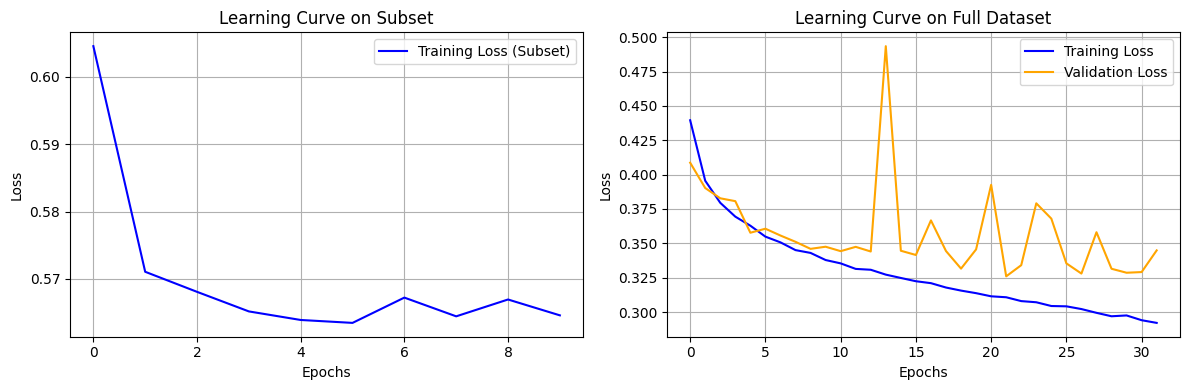

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/training_data.pkl'

with open(file_path, 'rb') as f:
    data = pickle.load(f)

train_losses = data['train_losses']
val_losses = data['val_losses']

# Create an image with two subgraphs
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# First subplot: training loss for the first 10 epochs of a subset of the data
axes[0].plot(train_losses[:10], label='Training Loss (Subset)', color='blue')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Learning Curve on Subset')
axes[0].legend()
axes[0].grid(True)

# Second subplot: training and validation losses for the full dataset
axes[1].plot(train_losses[10:], label='Training Loss', color='blue')
axes[1].plot(val_losses, label='Validation Loss', color='orange')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Learning Curve on Full Dataset')
axes[1].legend()
axes[1].grid(True)

# Adjust spacing between subgraphs
plt.tight_layout()
plt.show()

Accuracy: 0.8569
Recall: 0.7697
Precision: 0.8622
F1 Score: 0.8134
ROC-AUC: 0.9214


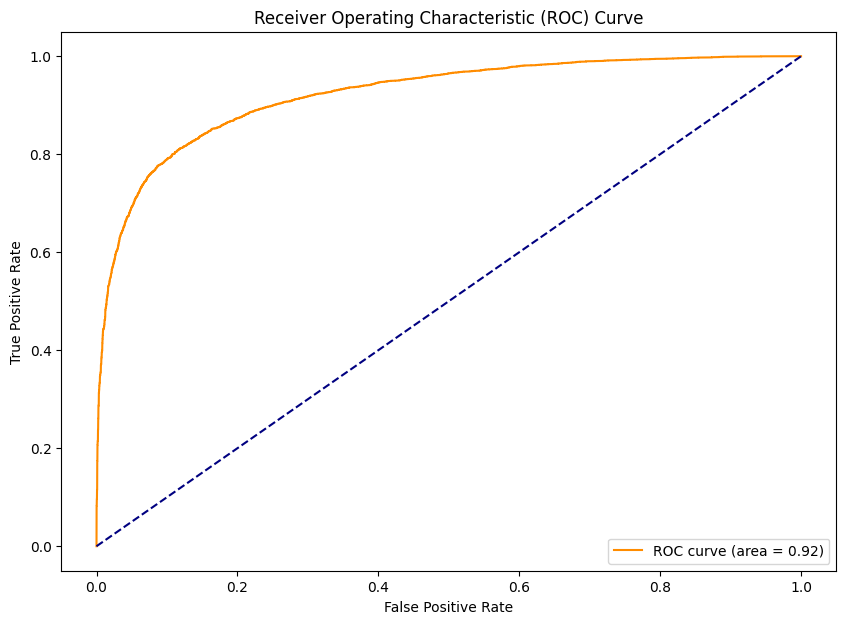

In [7]:
#Performance Evaluation
def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []
    all_probabilities = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)[:, 1]

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    return all_labels, all_predictions, all_probabilities

# Loading model weights
model_path = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/1st_train_model.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
labels, predictions, probabilities = evaluate_model(model, val_dataloader)

# Calculate metrics
accuracy = accuracy_score(labels, predictions)
recall = recall_score(labels, predictions)
precision = precision_score(labels, predictions)
f1 = f1_score(labels, predictions)
roc_auc = roc_auc_score(labels, probabilities)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(labels, probabilities)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [3]:
# Define the model, loss function, optimizer, and scheduler
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Load the trained model weights
model_path = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/1st_train_model.pth'
model.load_state_dict(torch.load(model_path))

criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Defining the Optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Adding a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Early stopping parameters
patience = 30
stop_count = 0
best_loss = float('inf')

# Training parameters
num_epochs = 300
validate_every = 1

# Lists to store results for plotting later
train_losses = []
val_losses = []

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


In [16]:
# Define a threshold for the learning rate below which training will be stopped
lr_threshold = 1e-6

# Ensure the entire model is trainable
for param in model.parameters():
    param.requires_grad = True

# Training loop with full dataset
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Training loop
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    # Validation loop
    if (epoch+1) % validate_every == 0:
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_dataloader.dataset)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")

        # Update the learning rate scheduler
        scheduler.step(val_loss)

        # Early stopping checks based on validation loss improvement
        if val_loss < best_loss:
            best_loss = val_loss
            stop_count = 0
            # Save the best model to the provided path
            torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/2st_model.pth')
        else:
            stop_count += 1

        # Additional early stopping check based on learning rate threshold
        current_lr = optimizer.param_groups[0]['lr']
        if current_lr < lr_threshold:
            print(f"Learning rate is below the threshold ({lr_threshold}). Early stopping!")
            break

        # Original early stopping check
        if stop_count >= patience:
            print("Early stopping due to lack of validation loss improvement!")
            break

# Save training data for plotting
training_data = {
    'train_losses': train_losses,
    'val_losses': val_losses
}
with open('/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/2st_training_data.pkl', 'wb') as f:
    pickle.dump(training_data, f)


Epoch 1/300, Training Loss: 0.4098
Epoch 1/300, Validation Loss: 0.4267
Epoch 2/300, Training Loss: 0.3922
Epoch 2/300, Validation Loss: 0.3996
Epoch 3/300, Training Loss: 0.3817
Epoch 3/300, Validation Loss: 0.3878
Epoch 4/300, Training Loss: 0.3713
Epoch 4/300, Validation Loss: 0.4312
Epoch 5/300, Training Loss: 0.3689
Epoch 5/300, Validation Loss: 0.3770
Epoch 6/300, Training Loss: 0.3614
Epoch 6/300, Validation Loss: 0.3590
Epoch 7/300, Training Loss: 0.3573
Epoch 7/300, Validation Loss: 0.3862
Epoch 8/300, Training Loss: 0.3567
Epoch 8/300, Validation Loss: 0.3744
Epoch 9/300, Training Loss: 0.3533
Epoch 9/300, Validation Loss: 0.3555
Epoch 10/300, Training Loss: 0.3489
Epoch 10/300, Validation Loss: 0.3568
Epoch 11/300, Training Loss: 0.3462
Epoch 11/300, Validation Loss: 0.3601
Epoch 12/300, Training Loss: 0.3422
Epoch 12/300, Validation Loss: 0.3498
Epoch 13/300, Training Loss: 0.3421
Epoch 13/300, Validation Loss: 0.3559
Epoch 14/300, Training Loss: 0.3378
Epoch 14/300, Valida

In [ ]:
# Define the model structure
model_structure = models.resnet18(pretrained=False)
num_features = model_structure.fc.in_features
model_structure.fc = nn.Linear(num_features, 2)

# Load the model weights
model_weights_path = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/2st_model.pth'
model_structure.load_state_dict(torch.load(model_weights_path))

# Print the model summary
model_structure = model_structure.to(device)
model_summary = summary(model_structure, input_size=(3, 224, 224))
model_summary


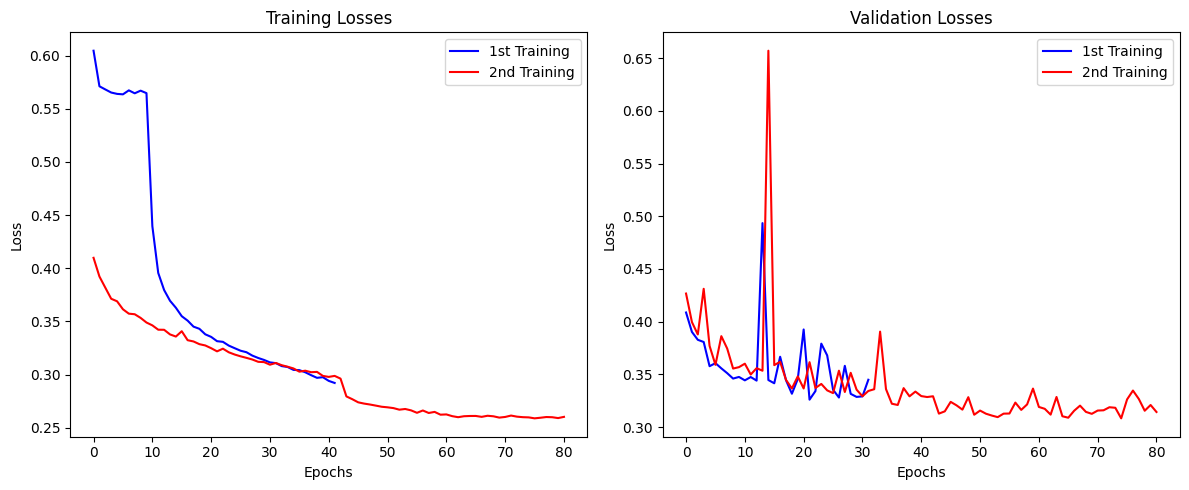

In [5]:
# Load the training data from the saved files
with open('/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/training_data.pkl', 'rb') as f:
    first_training_data = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/2st_training_data.pkl', 'rb') as f:
    second_training_data = pickle.load(f)

# Extracting train and validation losses for both training sessions
first_train_losses = first_training_data['train_losses']
first_val_losses = first_training_data['val_losses']

second_train_losses = second_training_data['train_losses']
second_val_losses = second_training_data['val_losses']

# Plotting the training and validation losses
plt.figure(figsize=(12, 5))

# Plotting training losses
plt.subplot(1, 2, 1)
plt.plot(first_train_losses, label='1st Training', color='blue')
plt.plot(second_train_losses, label='2nd Training', color='red')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting validation losses
plt.subplot(1, 2, 2)
plt.plot(first_val_losses, label='1st Training', color='blue')
plt.plot(second_val_losses, label='2nd Training', color='red')
plt.title('Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy: 0.8714
Recall: 0.8023
Precision: 0.8700
F1 Score: 0.8348
ROC-AUC: 0.9389


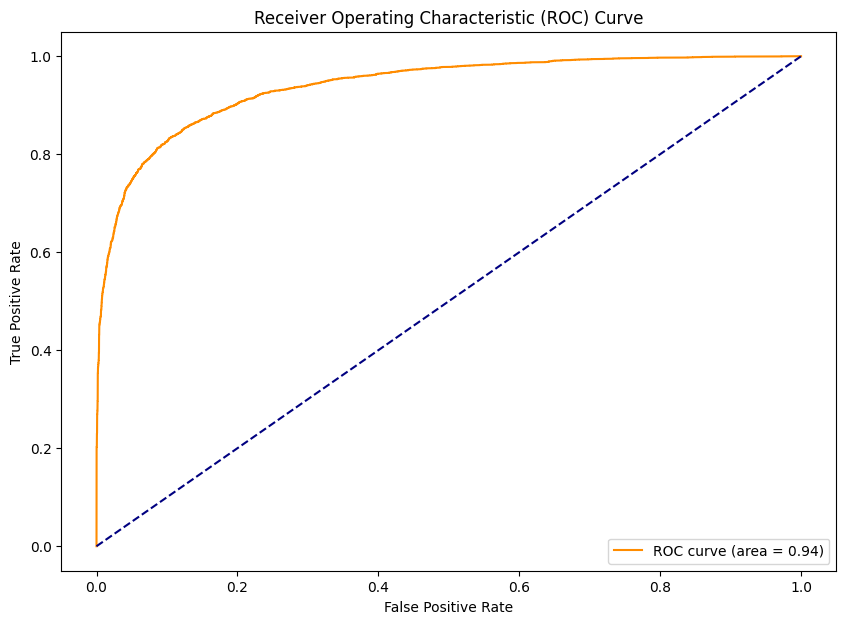

In [8]:
# Loading model weights
model_path = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/2st_model.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
labels, predictions, probabilities = evaluate_model(model, val_dataloader)

# Calculate metrics
accuracy = accuracy_score(labels, predictions)
recall = recall_score(labels, predictions)
precision = precision_score(labels, predictions)
f1 = f1_score(labels, predictions)
roc_auc = roc_auc_score(labels, probabilities)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(labels, probabilities)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [6]:
# Define the model and load the weights
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model_path = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/2st_model.pth'
model.load_state_dict(torch.load(model_path))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Defining datasets and data loaders
class TestDatasetFromHDF5(Dataset):
    def __init__(self, h5_file):
        with h5py.File(h5_file, 'r') as db:
            self.images = db['images'][:]
            self.image_names = db['file_names'][:]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image = self.images[index]
        image_name = self.image_names[index]
        return image, image_name

data_path = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/test_data_normal.h5'
test_dataset = TestDatasetFromHDF5(data_path)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Predicting test data using models
predictions = []
with torch.no_grad():
    for images, image_names in test_dataloader:
        images = images.float().to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for idx, image_name in enumerate(image_names):
            predictions.append((image_name.decode('utf-8'), predicted[idx].item()))





In [8]:
# Save the prediction results as a CSV file
output_csv_path = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/predictions.csv'
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['id', 'label'])  # CSV header
    for row in predictions:
        csvwriter.writerow(row)

In [9]:
import pandas as pd

# File paths
input_csv_path = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/predictions.csv'
output_csv_path_cleaned = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/predictions_cleaned.csv'

# Read the CSV file
df = pd.read_csv(input_csv_path)

# Use regex to ensure only the .tif at the end of the string is removed
df['id'] = df['id'].str.replace(r'\.tif$', '')

# Save the cleaned dataframe to a new CSV file
df.to_csv(output_csv_path_cleaned, index=False)


<ipython-input-9-0650fe2eb66d>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df['id'] = df['id'].str.replace(r'\.tif$', '')
